In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import gsw.density as gsw_d
import gsw.conversions as gsw_c
import warnings
import os
from eofs.xarray import Eof
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')

### ======================================================================

pthmd='J:/tmp_proc/Models/'
pthob='J:/tmp_proc/Obs/'

myEEMD_pth='C:/Users/shjo/OneDrive/mySO01/SCP_EEMD/OHC700_1993_2020_225E255E_65S45S/Figs/'

wpth='C:/Users/shjo/OneDrive/mySO/Sections/Vertical_EOFS/'

vrnm='temp'
t_rng=['1993-01', '2017-12']
d_rng=[0,2000]
lat_rng=[-75,-30]; lon_rng=[230,250]

tmp_sv_nm=''
### Preparation ============================================================
wpth=wpth+vrnm+'_'+str(t_rng[0][:4])+'_'+str(t_rng[-1][:4])+'_'+\
    str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+'_'+str(lon_rng[0])+\
        'E'+str(lon_rng[-1])+'E'+'/'
wpth=wpth.replace('-','')
try :
    os.mkdir(wpth)
except:
    pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth)

myMdls=[pthmd+i for i in os.listdir(pthmd) if i.endswith('.nc')]
myObsv=[pthob+i for i in os.listdir(pthob) if i.endswith('.nc')]

myDATA=myMdls+myObsv

if int(t_rng[0][:4])<1992:
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myECCO')]
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myARMOR3D')]
myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myISAS')]



In [2]:
### Figure Configurations ==============================================================
myN=20

figdepth=[-250, -500, -1000, -1500,-2000]
# mydepth=[-250, -500, -800]
fac=100
# mylevels2=[26.5,27,27.2,27.5,27.7,27.8]

In [6]:
print('!!! Open files !!!')
myEofs,myNm,myLat,mydepth=[],[],[],[]
myPcs,myVar,myVar2=[],[],[]
### Read Data ==============================================================
for i in myDATA:
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)

    mydata = tmp.loc[dict(lat=slice(lat_rng[0],lat_rng[-1]),lon=slice(lon_rng[0],lon_rng[-1])\
        ,time=slice(t_rng[0],t_rng[-1]),depth=slice(d_rng[0],d_rng[-1]))]
    mydata=mydata.where(mydata<10**30)
    mydata=mydata.mean(dim='lon',skipna=True)
    
    temp_=mydata['temp'].mean(dim='time').squeeze()
    salt_=mydata['salt'].mean(dim='time').squeeze()
    CT=gsw_c.CT_from_pt(salt_,temp_) #CT = gsw_CT_from_pt(SA,pt)
    rho = gsw_d.sigma0(salt_,CT)

    myvrnm=mydata[vrnm]
    
    time,latR,depthR=mydata.time.values,mydata.lat.values,mydata.depth.values
    
    dta_nm=i.split('/')[-1][2:-3].split('_')[0]+'_eof_'+\
        wpth.split('/')[-2]  
    
    myvrnm_1Y=myvrnm.rolling(time=12,center=True).mean()[6:-5]

    ### EOFs ==================================================================
    NN=10
    solver=Eof(myvrnm_1Y)
    eofs = solver.eofs(neofs=NN, eofscaling=0)
    pcs = solver.pcs(npcs=NN,pcscaling=0)
    var_=solver.varianceFraction(NN)*100
    var=var_/np.sum(var_)*100
        
    myEofs.append(eofs); myNm.append(dta_nm.replace('_',' ')); myLat.append(latR); mydepth.append(depthR)
    myPcs.append(pcs); myVar.append(var); myVar2.append(var_) 

mydata={'myEofs':myEofs,'myPcs':myPcs,'myNm':myNm,'myLat':myLat,'myDepth':mydepth,'myVar':myVar,'myVar2':myVar2}
with open(wpth+'EOF_vertical_'+wpth.split('/')[-2]+'.pickle', 'wb') as f:
    pickle.dump(mydata, f, pickle.HIGHEST_PROTOCOL)



!!! Open files !!!
!!! Open: J:/tmp_proc/Models/myECCO_199201_201712_tsh.nc !!!
!!! Open: J:/tmp_proc/Models/myGECCO_195501_201712_ztsuv2.nc !!!
!!! Open: J:/tmp_proc/Obs/myARMOR3D_SO_199301_202312_tsh.nc !!!
!!! Open: J:/tmp_proc/Obs/myCORA_1rg_196001_202212_tsh.nc !!!
!!! Open: J:/tmp_proc/Obs/myEN4_195501_202212_tsh.nc !!!
!!! Open: J:/tmp_proc/Obs/myIAP_195501_202212_tshuv.nc !!!
!!! Open: J:/tmp_proc/Obs/myISHII_195501_202212_tsh.nc !!!


In [4]:

def Vertical_data_drift03_(latR_m,depthR_m,dataR,mydepth,CMAP,myLevels1,dt_nm,snm):
    Label_size=12
    xtick_location = np.around(np.linspace(latR_m[0,0], latR_m[-1,-1],5))
    xtick_location = np.around(np.arange(latR_m[0,0]-1,latR_m[-1,-1]+1,5)+0.75)
    xtick_labels = [f'{-ii:2.0f}S' for ii in xtick_location]
    ytick_location= mydepth
    ytick_labels  = [f'{-ii:2.0f}m' for ii in ytick_location]
    # Figures
    fig, axs = plt.subplots(1,1,figsize=(8,4),
                            sharex=True,gridspec_kw={'height_ratios': [1],'wspace':0, 'hspace':0.05},dpi=200)
    axs.set_title(dt_nm,loc='right',fontdict={'fontsize':Label_size+4,'fontweight':'regular'})
    axs.axvline(x=-60,ls='--',color='k')
    axs.axvline(x=-50,ls='--',color='k')
    
    im1=axs.contourf(latR_m,depthR_m,dataR,cmap=CMAP,levels=myLevels1)
    axs.tick_params(axis='x', direction='in', length=4.5, pad=8, labelsize=Label_size, labelcolor='k', top=True)
    axs.tick_params(axis='y', direction='in', length=4.5, pad=8, labelsize=Label_size, color='k',right=True)
    axs.set_xlim(latR_m[0,0],latR_m[-1,-1])
    # im0=axs.contour(latR_m,depthR_m,dataR,\
    #     colors='k',levels=myLevels2,linestyle='-')
    # axs.clabel(im0, inline=1, fontsize=10)
    axs.set_xticks(ticks=xtick_location)
    axs.set_xticklabels(xtick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_yticks(ticks=ytick_location)
    axs.set_yticklabels(ytick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_facecolor(color='#dddddd')
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("bottom", size="7%", pad=.35)
    cax.tick_params(labelsize=Label_size)
    cax.set_ylabel('',{'fontsize':Label_size,'fontweight':'bold','style':'italic'})
    h = fig.colorbar(im1, ax=axs,label='',cax=cax,orientation="horizontal",extend='both',aspect=50)
    if 1:
        # plt.savefig('',facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(snm,bbox_inches='tight')
    plt.show()

def plot_pcs(time,time2,pc,t_name,w_path,fig_bool=True):
    Label_size = 18
    fig, axs = plt.subplots(1,1,figsize=(10,3.7),constrained_layout = True,
                        dpi=200)
    f1 = axs.plot(time,pc, label='KINETIC_ENRG',color='k',linewidth=2,zorder=0)
    axs.set_title(t_name,loc='right',fontdict={'fontsize':20,'fontweight':'regular','fontstyle':'italic'})
    axs.tick_params(axis='both', labelsize=Label_size)
    axs.grid(axis='x',linestyle='-.')
    xtick_location = time[5::12*4]
    xtick_labels = time2[5::12*4]
    axs.set_xticks(ticks=xtick_location)
    axs.set_xticklabels(xtick_labels, rotation=0, fontsize=Label_size, alpha=1)
    axs.tick_params(axis='x', direction='in', length=6, pad=8, labelsize=Label_size, labelcolor='k', top=True,width=1.)
    axs.tick_params(axis='y', direction='in', length=6, pad=8, labelsize=Label_size-3, width=1., color='k')
    plt.tight_layout()
    if fig_bool:
        # plt.savefig(w_path+Dir_pth+'/ppt/'+save_name,
        #         facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(w_path,bbox_inches='tight')
    plt.show()


!!! Write figures !!!
!!! Write: C:/Users/shjo/OneDrive/mySO/Sections/Vertical_EOFS/temp_1993_2017_75S30S_230E250E/ECCO_eof_temp_1993_2017_75S30S_230E250E !!!


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/shjo/OneDrive/mySO/Sections/Vertical_EOFS/temp_1993_2017_75S30S_230E250E/ECCO_eof_temp_1993_2017_75S30S_230E250E/ECCO_eof_temp_1993_2017_75S30S_230E250E_01mode_eof.png'

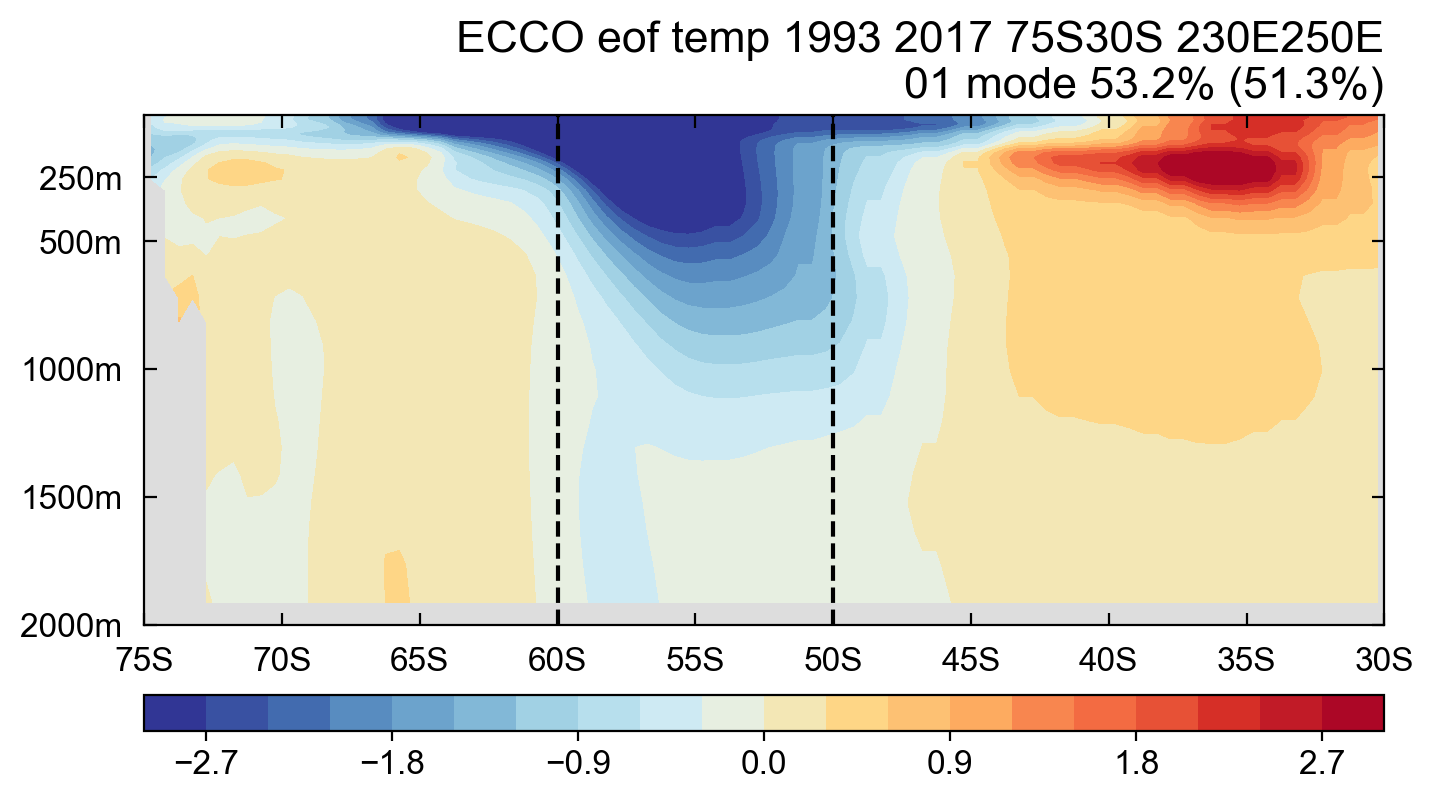

In [21]:
### Write figure ====================================================
mylim=[-3,3]
myN=20

print('!!! Write figures !!!')
for nm,lat_,depth_,eofs_,pcs_,var1_,var2_ in zip(myNm,myLat,mydepth,myEofs,myPcs,myVar,myVar2):
    snm=wpth+nm.replace(' ','_')
    print('!!! Write: '+snm+' !!!')
    try :
        os.mkdir(snm.replace(' ','_'))
    except:
        pass

    for eof,pc,var1,var2,N in zip(eofs_.values,pcs_.transpose(),var1_,var2_,range(1,len(eofs_)+1)):
        
        eof=eof*fac
        
        eof[eof<mylim[0] ]=mylim[0]
        eof[eof>mylim[-1]]=mylim[-1]
        
        TIME= [str(i)[0:7] for i in pcs_.time.values]
        TIME2=[str(i)[2:4] for i in pcs_.time.values]

        latM,depthM=np.meshgrid(lat_,depth_)
        CMAP,mylevel=myClrbr('b2r',mylim,myN)



        t_nm=nm+f'\n{N:02d}'+' mode '+f'{var1:.1f}'+'% ('+f'{var2:.1f}'+'%)'
        s_nm=snm+'/'+nm.replace(' ','_')+'_'+f'{N:02d}'+'mode'


        Vertical_data_drift03_(latM,-depthM,eof,figdepth,CMAP,mylevel,t_nm,s_nm+'_eof')
        Vertical_data_drift03_(latM,-depthM,-eof,figdepth,CMAP,mylevel,t_nm,s_nm+'_eof')

        plot_pcs(TIME,TIME2,pc/fac,t_nm.replace('eof','pc'),s_nm+'_pc',fig_bool=True)
        plot_pcs(TIME,TIME2,-pc/fac,t_nm.replace('eof','pc'),s_nm+'_pc_re',fig_bool=True)
        
        
        